Data Shape: (72000, 28)

Sample Data:
   student_id term   age gender ethnicity  first_generation_flag        major  \
0  HSU100000   T1  18.0      M  Hispanic                      0  Mathematics   
1  HSU100000   T2  18.5      M  Hispanic                      0  Mathematics   
2  HSU100000   T3  19.0      M  Hispanic                      0  Mathematics   
3  HSU100000   T4  19.5      M  Hispanic                      0  Mathematics   
4  HSU100001   T1  18.0      F  Hispanic                      0  Engineering   

  residence enrollment_status  credits_attempted  ...  discussion_posts  \
0  Commuter         Full-time                 18  ...                 0   
1  Commuter         Full-time                 18  ...                 3   
2  Commuter         Full-time                 18  ...                 2   
3  Commuter         Full-time                 18  ...                 3   
4  Commuter         Full-time                 18  ...                 3   

   library_visits  financial_

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:24:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Results
Accuracy: 0.9985416666666667
ROC-AUC: 0.9971255434589205
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12899
           1       0.99      1.00      0.99      1501

    accuracy                           1.00     14400
   macro avg       1.00      1.00      1.00     14400
weighted avg       1.00      1.00      1.00     14400


🔹 Gradient Boosting Results
Accuracy: 0.9998611111111111
ROC-AUC: 0.9996281260460569
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12899
           1       1.00      1.00      1.00      1501

    accuracy                           1.00     14400
   macro avg       1.00      1.00      1.00     14400
weighted avg       1.00      1.00      1.00     14400



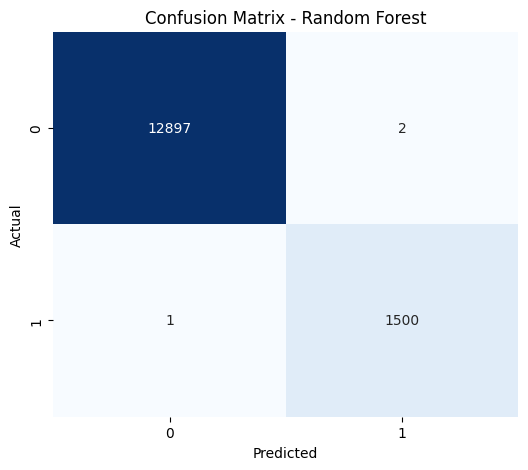

/tmp/ipython-input-1041707379.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='coolwarm')


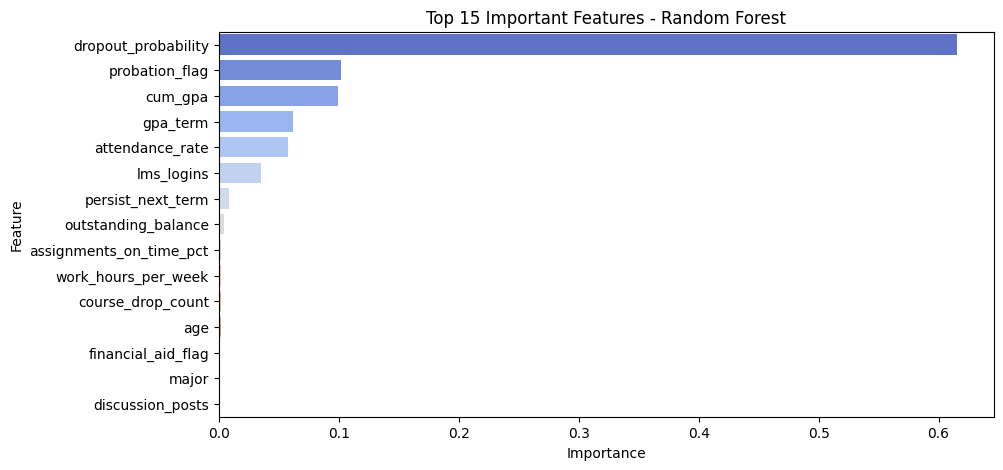


✅ Predictions saved to 'student_risk_predictions.csv' successfully!


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

df = pd.read_csv("/content/HSU_Student_Success_Data.csv")

print("Data Shape:", df.shape)
print("\nSample Data:\n", df.head())
print("\nColumns:\n", df.columns.tolist())
df = df.drop(columns=['student_id', 'term'])

print("\nMissing Values per Column:\n", df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns:", categorical_cols)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
X = df.drop(columns=['at_risk_flag'])
y = df['at_risk_flag']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("\n🔹 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n🔹 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n🔹 XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("\n🔹 Gradient Boosting Results")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


best_model = rf_model  # Random Forest usually performs best
y_pred_best = y_pred_rf

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(10,5))
sns.barplot(x=importances.values, y=importances.index, palette='coolwarm')
plt.title("Top 15 Important Features - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


probabilities = rf_model.predict_proba(X_test)[:, 1]
results_df = pd.DataFrame({
    "Actual_At_Risk": y_test.values,
    "Predicted_At_Risk": y_pred_best,
    "Risk_Probability": probabilities
})

results_df.to_csv("student_risk_predictions.csv", index=False)
print("\n✅ Predictions saved to 'student_risk_predictions.csv' successfully!")

